In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm
from scipy import integrate
import pandas as pd
import cv2
pd.set_option('precision', 12)

# Punto 1

In [2]:
def crear_matriz(theta, k, M):
    return np.array([
        [np.sin(theta), np.cos(theta), -np.sin(theta), -np.cos(theta), 1, 1], 
        [0, M, 0, 1, 0, 0], 
        [M, 0, 1, 0, 0, 0],
        [-np.cos(theta), np.sin(theta), np.cos(theta), -np.sin(theta), 0, 0], 
        [np.sin(theta), np.cos(theta), 0, 0, -k, 0], 
        [0, 0, np.sin(theta), np.cos(theta), 0, k]
    ])

def crear_vector(theta, e, M, u1):
    return np.array([0, 0, M*u1, e*u1*np.cos(theta), e*u1*np.sin(theta), 0])

In [3]:
def gauss_jordan(M, B):
    m = M.copy()
    b = B.copy()
    
    m = np.float_(m)
    b = np.float_(b)
    
    b = np.resize(b, (6, 1))
    
    B = np.append(m, b, axis=1)
    
    n = B.shape[0]
    
    for i in range(n):
        indi_max = np.argmax(np.abs(B[i:, i]))
        if indi_max > 0:
            C = B[i].copy()
            B[i] = B[i + indi_max]
            B[i + indi_max] = C
        a = B[i,i]
        B[i,:] = B[i,:]/a
        for j in range(i+1, n):
            a = B[j,i]
            B[j,:] = B[j,:]-a*B[i,:] 
    
    for i in range(n-1,-1,-1):
        for j in range(i+1, n):
            B[i] = B[i] - B[i,j]*B[j]
    return B
            

In [4]:
def posibles_estados_finales(k, M, u1, e):
    thetas = np.linspace(0, np.pi/2, 100)
    sol = np.zeros((100,6))
    
    for i in range(len(thetas)):
        matriz = crear_matriz(thetas[i], k, M)
        b = crear_vector(thetas[i], e, M, u1)
        
        solucion = gauss_jordan(matriz, b)
        sol[i, :] = solucion[:,-1]
    return sol, thetas

In [5]:
k = 0.5
M = 1.5
u1 = 2
e = 0.8

est_finales, thetas = posibles_estados_finales(k, M, u1, e)

In [6]:
def obtener_w1_w2(solucion, R1, R2):
    w1 = solucion[:, -2]/R1
    w2 = solucion[: ,-1]/R2
    return w1, w2

In [7]:
def obtener_v1_v2(solucion):
    v1_x1 = solucion[:, 0]**2
    v1_y1 = solucion[:, 1]**2
    v1 = np.sqrt(v1_x1 + v1_y1)
    v2_x2 = solucion[:, 2]**2
    v2_y2 = solucion[:, 3]**2
    v2 = np.sqrt(v2_x2 + v2_y2)
    return v1, v2

In [8]:
def plot_w1_w2(w1, w2):
    plt.plot(w1, w2, '.')
    plt.xlabel(r'Velocidad angular $\omega_1$')
    plt.ylabel(r'Velocidad angular $\omega_2$')
    plt.title(r'$\omega_1 \ vs \ \omega_2$ para la colision entre 2 discos rigidos')
    plt.show()

In [9]:
def plot_v_w(w, v, num_disco):
    plt.plot(v, w, '.')
    plt.ylabel(r'Velocidad angular $\omega$')
    plt.xlabel(r'Velocidad lineal $v$')
    plt.title(r'$\omega \ vs \ v$ para la colision el disco rigido {}'.format(num_disco))
    plt.show()

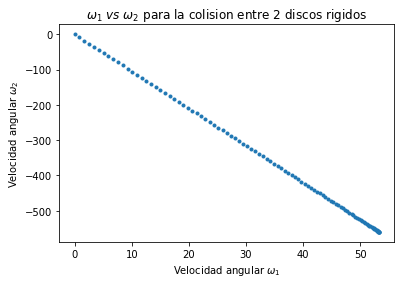

In [10]:
R1, R2 = 0.1e-2, 0.2e-2
w1, w2 = obtener_w1_w2(est_finales, R1, R2)
v1, v2 = obtener_v1_v2(est_finales)
plot_w1_w2(w1, w2)

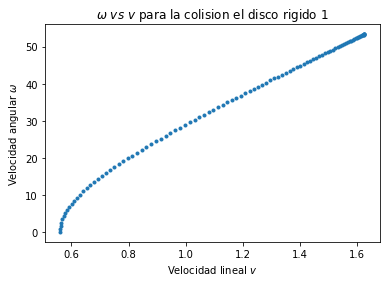

In [11]:
plot_v_w(w1, v1, 1)

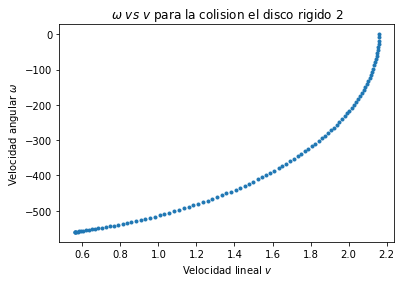

In [12]:
plot_v_w(w2, v2, 2)

In [13]:
#matriz = crear_matriz(5.2, k, M)
#b = crear_vector(5.2, e, M, u1)

#print(gauss_jordan(matriz, b)[:, -1])
#invM = np.linalg.inv(matriz)
#print(invM @ b)

# Punto 2

In [14]:
k = 8.987*10**9
p = 1.602*10**-19
magnitud = k*p
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X,Y = np.meshgrid(x,y)

In [15]:
def crear_cargas_en_circulo(carga, N=1000, R=0.2):
    angulos = np.linspace(0, 2*np.pi, N, endpoint=False)
    c = 1.0*p
    X, Y, cargas = [], [], []
    #x = [(R*np.cos(angulo), R*np.sin(angulo), carga) for angulo in angulos]
    for angulo in angulos:
        X.append(R*np.cos(angulo))
        Y.append(R*np.sin(angulo))
        cargas.append(c)
    return X, Y, cargas

In [16]:
def plot_cargas(X_fuente, Y_fuente, N, R):
    plt.figure(figsize=(6,6))
    plt.plot(X_fuente, Y_fuente, '.', color='#83eb7a')
    plt.title('Arreglo circular de {} cargas con R={}'.format(N,R))
    plt.show()

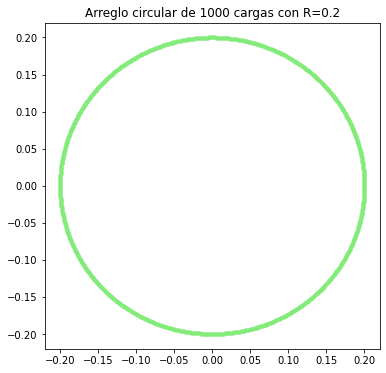

In [17]:
N, R = 1000, 0.2
X_fuente, Y_fuente, cargas = crear_cargas_en_circulo(p, N, R)
plot_cargas(X_fuente, Y_fuente, N, R)

In [18]:
def campo_electrico(X, X_fuente, Y, Y_fuente, cargas, e=0.01):
    x_componente = (cargas*k*(X - X_fuente))/((X - X_fuente)**2 + (Y - Y_fuente)**2 + e)**1.5
    y_componente = (cargas*k*(Y - Y_fuente))/((X - X_fuente)**2 + (Y - Y_fuente)**2 + e)**1.5
    return x_componente, y_componente

In [19]:
def magnitud_campo_electrico(campo, X, X_fuente, Y, Y_fuente, cargas, magnitud):
    X_total, Y_total = 0,0 
    for i in range(len(X_fuente)):
        x_componente, y_componente = campo(X, X_fuente[i], Y, Y_fuente[i], cargas[i])
        X_total += x_componente
        Y_total += y_componente
    return np.sqrt(X_total**2 + Y_total**2)/magnitud

In [20]:
E = magnitud_campo_electrico(campo_electrico, X, X_fuente, Y, Y_fuente, cargas, magnitud)

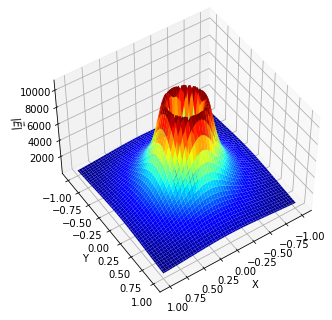

In [21]:
fig = plt.figure()
ax = Axes3D(fig, elev = 48, azim = 56)
ax.plot_surface(X,Y, E, cmap=cm.jet, linewidth=1.0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$|\vec{E}|$')
plt.show()

In [22]:
def potencial(X_i, X_k, Y_i, Y_k, cargas, e=0.01):
    return cargas*k/((X_i - X_k)**2 + (Y_i - Y_k)**2 + e)**(1/2)

In [23]:
def potencial_total(V, X_i, X_k, Y_i, Y_k, cargas, k):
    V_total = 0
    for i in range(len(X_k)):
        if X_i != X_k[i] and Y_i != Y_k[i]:
            V_total += V(X_i, X_k[i], Y_i, Y_k[i], cargas[i])
    return k*V_total

In [24]:
X, Y, cargas = crear_cargas_en_circulo(p, N, R)
voltajes = []
for i in range(len(X)):
    volt = potencial_total(potencial, X[i], X, Y[i], Y, cargas, k)
    voltajes.append(volt)
voltajes = np.array(voltajes)
cargas = np.array(cargas)

In [25]:
E_Potencial = sum(voltajes*cargas)/2
print(E_Potencial)

4.514762714597339e-12


# Punto 3

In [26]:
def leer_datos(ruta):
    datos = np.loadtxt(ruta)
    return datos

In [27]:
def obtener_tensor_de_inercia(m, datos, dim):
    tensor_de_inercia = np.zeros((dim, dim))
    producto_tensorial = np.zeros((dim, dim))
    tensor_unitario = np.array([[1, 0, 0],
                                [0, 1, 0],
                                [0, 0, 1]])
    n = len(datos[:, 0])
    for k in range(n):
        producto_punto = datos[k, :] @ datos[k, :]
        for i in range(dim):
            for j in range(dim):
                producto_tensorial[i,j] = datos[k, i] * datos[k, j]
        
        tensor_de_inercia += m*(tensor_unitario*producto_punto - producto_tensorial)
    return tensor_de_inercia

In [28]:
ruta = './data/CuerposCelestes.dat'
m = 1.0
dim = 3
datos_estrella = leer_datos(ruta)
tensor_de_inercia = obtener_tensor_de_inercia(m, datos_estrella, dim)
print(tensor_de_inercia)

[[ 1.11638178e+04  2.05248547e+00  7.42865762e-01]
 [ 2.05248547e+00  8.95207032e+03 -2.34834623e+03]
 [ 7.42865762e-01 -2.34834623e+03  4.23411270e+03]]


In [29]:
def eigen_valores_vectores(tensor):
    eigen_valores, eigen_vectores = np.linalg.eig(tensor_de_inercia)
    return eigen_valores, eigen_vectores

In [30]:
eigen_valores, eigen_vectores = eigen_valores_vectores(tensor_de_inercia)
print('Los eigenvalores de este tensor de inercia son:\n ', eigen_valores)
print()
print('Los eigenvectores de este tensor de inercia son:\n ', eigen_vectores)

Los eigenvalores de este tensor de inercia son:
  [11163.82020505  9921.67935792  3264.50128356]

Los eigenvectores de este tensor de inercia son:
  [[ 9.99999139e-01  1.29907114e-03 -1.86085626e-04]
 [ 1.27176354e-03 -9.24310243e-01  3.81639828e-01]
 [-3.23776435e-04  3.81639736e-01  9.24311099e-01]]


In [31]:
def plot_estrella(eigen_vectores, datos):
    data_en_los_ejes = eigen_vectores @ datos.T
    fig = plt.figure(figsize=(7,5))
    ax = Axes3D(fig, elev = 18, azim = 9)
    X, Y, Z = datos[:, 0], datos[:, 1], datos[:, 2]
    X1, Y1, Z1 = data_en_los_ejes[0], data_en_los_ejes[1], data_en_los_ejes[2]
   
    ax.set_xlabel(r'$X$')
    ax.set_ylabel(r'$Y$')
    ax.set_zlabel(r'$Z$')
    
    ax.set_xlim(-3.,3.)
    ax.set_ylim(-3.,3.)
    ax.set_zlim(-3.,3.)
    
    ax.scatter(X1, Y1, Z1, marker='.', color='green', zorder=0)
    ax.scatter(X, Y, Z, marker='.', zorder=5)
    
    for i in range(len(eigen_vectores)):
        xs = np.array([0,2*eigen_vectores[i,0]])
        ys = np.array([0,2*eigen_vectores[i,1]])
        zs = np.array([0,2*eigen_vectores[i,2]])
        ax.plot(xs,ys,zs, marker='*', color='red', zorder=10)

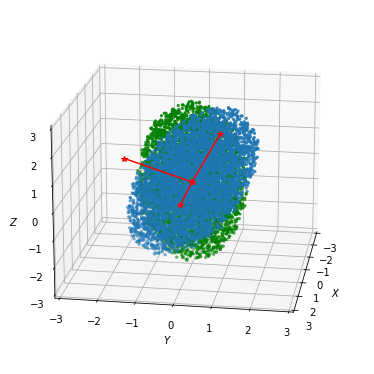

In [32]:
plot_estrella(eigen_vectores, datos_estrella)

# Punto 4

In [33]:
def funcion(t):
    return t**2

In [34]:
def serie_fourier(f, t, N, T):
    
    a0, error = integrate.quad(lambda t: f(t), -0.5*T, 0.5*T)
    a0 *= 2/T
    
    y = a0/2
    
    for n in range(1, N+1):
        
        an, erroran = integrate.quad(lambda t: f(t)*np.cos( (2*np.pi*n*t)/T ), -0.5*T, 0.5*T)
        an *= 2/T
        
        bn, errorbn = integrate.quad(lambda t: f(t)*np.sin( (2*np.pi*n*t)/T ), -0.5*T, 0.5*T)
        bn *= 2/T
        y += an*np.cos(2*np.pi*n*t/T) + bn*np.sin(2*np.pi*n*t/T)
    
    return y

In [35]:

t = np.linspace(-np.pi, np.pi, 1000)
N = 10
T = 2*np.pi
y = funcion(t)
y_furier = serie_fourier(funcion, t, N, T)

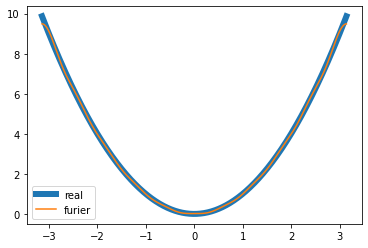

In [36]:
plt.plot(t, y, linewidth = 6, label = 'real')
plt.plot(t, y_furier, label = 'furier')
plt.legend()

Para conseguir la sumatoria, se realizó la integral de $t^2$ y su respectiva regla de fourier y luego se aplicó la identidad de parseval. Procedimiento que se encuentra en el PDF. Se encontró entonces que

$$\frac{1}{16\pi} \int_{-pi}^{pi}\left (\frac{t^3}{3} - \frac{\pi^2 t}{3} \right )^2 dt = \sum_{n=1}^{\infty} \frac{1}{n^6}$$

Ahora calcularemos la integral de forma numérica

In [37]:
resultado_real = np.pi**6/945

In [38]:
def func(t):
    return (((t**3)/3)-(((np.pi**2)*t)/3))**2

def gauss_legendre_integrate_ab(f, X, W, a, b):
    c1 = 0.5*(b-a)
    c2 = 0.5*(a+b)
    return c1*np.sum(W*f(c1*X + c2))

w_5 = [128/225] + [(322 + 13*np.sqrt(70))/900, (322 - 13*np.sqrt(70))/900]*2 
x_5 = np.array([0, (1/3)*np.sqrt(5 - 2*np.sqrt(10/7)), (1/3)*np.sqrt(5 + 2*np.sqrt(10/7)),  
               (-1/3)*np.sqrt(5 - 2*np.sqrt(10/7)), (-1/3)*np.sqrt(5 + 2*np.sqrt(10/7))])

integral= gauss_legendre_integrate_ab(func, x_5, w_5, -np.pi, np.pi)
print(integral/(16*np.pi))
print(resultado_real)

1.0173430619844492
1.017343061984449


# Punto 5

In [39]:
def leer_y_filtrar_datos(ruta):
    datos = np.loadtxt(ruta)
    df = pd.DataFrame(data=datos, columns=['Anio', 'Mes', '', 'NumManchas', ''])
    df = df[['Anio','Mes','NumManchas']]
    #Quitamos los datos que esten antes de 1900
    df = df[df['Anio'] >= 1900]
    #Debemos ponerlos en unidades de anio
    df['UniAnio'] = df['Anio'] + df['Mes']/12
    #Nos quedamos unicamente con las columnas que nos interesan
    df = df[['UniAnio', 'NumManchas']]
    return df

In [40]:
def plot_manchas_1900(df, col1, col2):
    fig = plt.figure(figsize=(10,5))
    plt.xlabel(r'Años')
    plt.ylabel(r'Frecuencia de manchas solares')
    plt.plot(df[col1], df[col2])

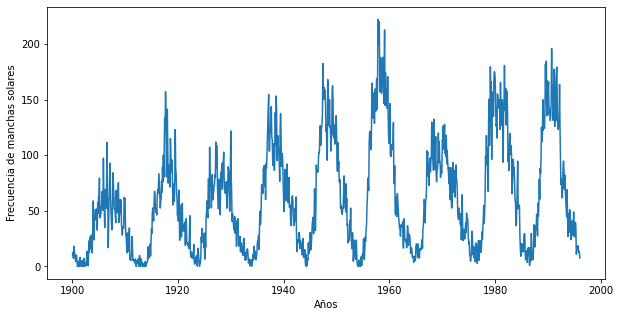

In [41]:
ruta = './data/ManchasSolares.dat'
datos_manchas_solares = leer_y_filtrar_datos(ruta)
plot_manchas_1900(datos_manchas_solares, 'UniAnio', 'NumManchas')

In [42]:
def frec_centrada_en_cero(df, col):
    media = df[col].mean()
    df[col] = df[col] - media
    return df, media

In [43]:
def plot_manchas_frec_cero(df, media, col1, col2):
    fig = plt.figure(figsize=(10,5))
    plt.xlabel(r'Años')
    plt.ylabel(r'Frecuencia de manchas solares centrada en 0')
    plt.plot(df[col1], df[col2])

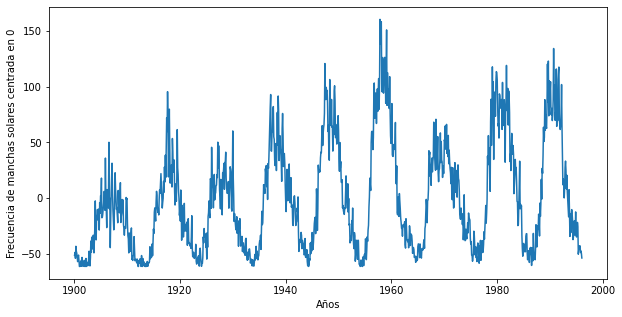

In [44]:
manchas_solares_frec_cero, media = frec_centrada_en_cero(datos_manchas_solares, 'NumManchas')
manchas_solares = manchas_solares_frec_cero['NumManchas']
fechas = manchas_solares_frec_cero['UniAnio']
plot_manchas_frec_cero(manchas_solares_frec_cero, media, 'UniAnio', 'NumManchas')

In [45]:
def transformada_fourier_y_frecuencias(manchas):
    n = len(manchas)
    FFT = np.fft.fft(manchas)
    frecuencias = np.fft.fftfreq(n, 1)
    return FFT, frecuencias

In [46]:
def transformada_fourier_absoluta(FFT):
    return np.abs(FFT)

In [47]:
def plot_FFTA(FFTA, manchas):
    fig = plt.figure(figsize=(10,5))
    n = np.linspace(1, len(manchas), len(manchas), endpoint=False)
    plt.scatter(n, FFTA/len(manchas))
    plt.stem(n, FFTA/len(manchas), use_line_collection=True)

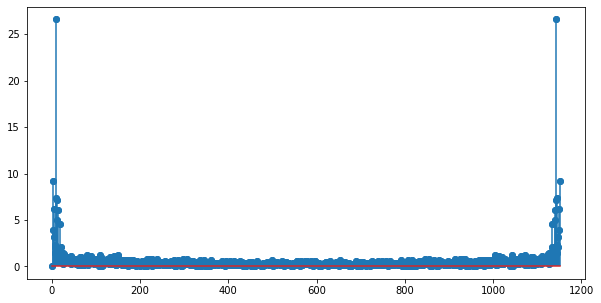

In [48]:
FFT, frecuencias = transformada_fourier_y_frecuencias(manchas_solares)
frecuencias_absolutas = np.abs(frecuencias)
FFTA = transformada_fourier_absoluta(FFT)
#print(manchas_solares_frec_cero)
plot_FFTA(FFTA, manchas_solares)

In [49]:
def frecuencia_dominante(FFTA_):
    frec_dominante = np.max(FFTA_)
    indice_frec_dominante = np.argmax(FFTA_)
    return frec_dominante, indice_frec_dominante

In [50]:
def frecuencias_no_dominantes_en_0(frec_abs, frecs, indi_frec_dom, FFTA_, FFT_):
    # Las frecuencias no dominantes son aquellas menores o mayores a la frecuencia dominante
    no_dominantes = (frec_abs < frecs[indice_frec_dominante]) | ((frec_abs > frecs[indice_frec_dominante]))
    # Las volvemos cero
    FFTA_[no_dominantes] = 0
    FFT_[no_dominantes] = 0
    return FFTA_, FFT_

In [51]:
frec_dominante, indice_frec_dominante = frecuencia_dominante(FFTA)
FFTA_dominante, FFT_dominante = frecuencias_no_dominantes_en_0(frecuencias_absolutas, frecuencias, indice_frec_dominante, FFTA, FFT)


In [52]:
def plot_FFTA(FFTA_, manchas):
    fig = plt.figure(figsize=(10,5))
    n = np.linspace(1, len(manchas), len(manchas), endpoint=False)
    plt.scatter(n, FFTA_/len(manchas))
    plt.stem(n, FFTA_/len(manchas), use_line_collection=True)

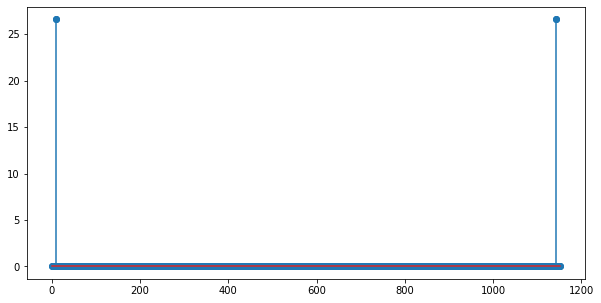

In [53]:
plot_FFTA(FFTA_dominante, manchas_solares)

In [54]:
def encontrar_periodo_por_anio(frecs, indice_frec_dom):
    return (1/frecs[indice_frec_dom])/12

In [55]:
periodo_por_anio = encontrar_periodo_por_anio(frecuencias, indice_frec_dominante)

In [56]:
def ifft_con_frecuencia_dominante(FFT_dom):
    return np.fft.ifft(FFT_dom)

In [57]:
def plot_con_frec_dominante(fecha, manchas, manchas_frec_dom, media_, periodo):
    fig = plt.figure(figsize=(10,5))
    plt.title(r'Periodo {:.2f} en años'.format(periodo))
    plt.plot(fecha, manchas + media_, label='Datos manchas solares')
    plt.plot(fecha, np.real(manchas_frec_dom)+media_, c='r', label='Frecuencia dominante')
    
    plt.xlabel('Frecuencia [1/mes]')
    plt.ylabel('Norma FFT')
    plt.legend()
    plt.savefig('images/Manchas_Solares.png')

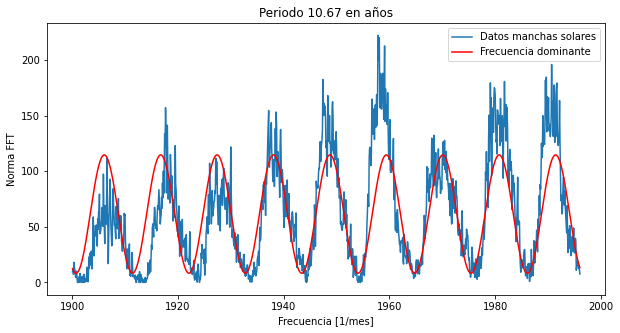

In [58]:
manchas_frecuencia_dominante = ifft_con_frecuencia_dominante(FFT_dominante)
plot_con_frec_dominante(fechas, manchas_solares, manchas_frecuencia_dominante, media, periodo_por_anio)

# Punto 6

Para este punto, se uso un metodo de deteccion de bordes con el fin de conocer la longitud de un lapiz. Para esto, se tomo foto a una regla, la cual media aproximadamente 20.8 cm. De esta forma se obtuvo un factor de conversión para pasar de pixeles a centímetros. Por su lado, el lapiz tiene una longitud aproximada de 15.3 cm. El resultado que se obtuvo fue de aproximadamente 15.5 cm, por lo que fue satisfactorio

In [14]:
def calcular_pixeles_por_centimetro(ruta_regla, tamanio_regla_cm, pixelesX, pixelesY):
    imagen = cv2.imread(ruta_regla)

    imagen = cv2.resize(imagen,(pixelesX,pixelesY))
    cv2.imshow('ImagenOriginal',imagen)
    
    kernel1 = np.array([-0.5,0,0.5])
    kernel2 = np.array([[-0.5],[0],[0.5]]) 
    
    X = cv2.filter2D(imagen, -1, kernel1)
    Y = cv2.filter2D(imagen, -1, kernel2)
    
    Mxy = np.sqrt(X**2 + Y**2)
    Mxy = Mxy/np.max(Mxy)
    
    mascara = np.where(Mxy > 0.80,255,0)
    mascara = np.uint8(mascara)
    cv2.imshow('mascara',mascara)
    
    mascara = np.where(Mxy > 0.80,255,0)
    
    u = np.zeros((Nx,Ny))

    pixeles_x = []
    pixeles_y = []

    for i in range(len(mascara[0,:])):
        for j in range(len(mascara[:,0])):
            if(mascara[i,j][0] == 255 and mascara[i,j][1] == 255 and mascara[i,j][2] == 255):
                u[i,j] = 1
                pixeles_x.append(i)
                pixeles_y.append(j)
    
    pixeles_filtrados = np.array([])

    for i in range(len(pixeles_x)):
        if(pixeles_x[i] < 1000 and pixeles_x[i] > 0):
            pixeles_filtrados = np.append(pixeles_filtrados,pixeles_x[i])
    
    x_min, x_max = np.min(pixeles_filtrados), np.max(pixeles_filtrados) 
    
    longitud_pixeles = x_max - x_min
    
    return longitud_pixeles/tamanio_regla_cm

In [15]:
def calcular_tamanio_lapiz(ruta_lapiz, factor_Conversion,  pixelesX, pixelesY):
    imagen = cv2.imread(ruta_regla)

    imagen = cv2.resize(imagen,(pixelesX,pixelesY))
    cv2.imshow('ImagenOriginal',imagen)
    
    kernel1 = np.array([-0.5,0,0.5])
    kernel2 = np.array([[-0.5],[0],[0.5]]) 
    
    X = cv2.filter2D(imagen, -1, kernel1)
    Y = cv2.filter2D(imagen, -1, kernel2)
    
    Mxy = np.sqrt(X**2 + Y**2)
    Mxy = Mxy/np.max(Mxy)
    
    mascara = np.where(Mxy > 0.80,255,0)
    mascara = np.uint8(mascara)
    cv2.imshow('mascara',mascara)
    
    mascara = np.where(Mxy > 0.80,255,0)
    
    u = np.zeros((Nx,Ny))

    pixeles_x = []
    pixeles_y = []

    for i in range(len(mascara[0,:])):
        for j in range(len(mascara[:,0])):
            if(mascara[i,j][0] == 255 and mascara[i,j][1] == 255 and mascara[i,j][2] == 255):
                u[i,j] = 1
                pixeles_x.append(i)
                pixeles_y.append(j)
            
    pixeles_filtrados = np.array([])

    for i in range(len(pixeles_x)):
        if(pixeles_x[i] < pixelesX-100 and pixeles_x[i] > 100):
            pixeles_filtrados = np.append(pixeles_filtrados,pixeles_x[i])
    
    x_min, x_max = np.min(pixeles_filtrados), np.max(pixeles_filtrados) 
    
    longitud_pixeles = x_max - x_min
    
    return longitud_pixeles/factor_Conversion

In [16]:
ruta_regla = 'fotos/Regla.jpg'
ruta_lapiz = 'fotos/Pinky.jpg'
tamanio_regla = 20.8
Nx = 1000
Ny = 1000

factor_conversion = calcular_pixeles_por_centimetro(ruta_regla, tamanio_regla, Nx, Ny)
calcular_tamanio_lapiz(ruta_lapiz, factor_conversion,  Nx, Ny)

15.532717190388171